### **🚀 Red Teaming: Adversarial Attacks to Test Your Credit Score Prediction Model**
Red teaming involves **attacking the model** to uncover weaknesses, biases, and vulnerabilities. Below is a structured Python code to **fool the system** using adversarial examples.

---

### **🔍 Attack Strategies**
We will implement:
1. **Evasion Attack**: Modify inputs to fool the model into predicting a different credit score category.
2. **Data Poisoning**: Inject biased data to see if the model learns incorrect patterns.
3. **Model Inversion Attack**: Reverse-engineer sensitive information from model outputs.
4. **Fairness Exploitation**: Identify cases where the model treats similar applicants unfairly.

---

### **🔍 What This Code Does**
✅ **Evasion Attack** → Modifies input to get a higher score  
✅ **Data Poisoning Attack** → Injects bad labels to corrupt training  
✅ **Model Inversion Attack** → Uses SHAP to reverse-engineer sensitive info  
✅ **Fairness Exploitation** → Finds unfair predictions  



In [3]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import random
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_absolute_error, r2_score

# -----------------------------
# 🚀 Step 1: Load and Prepare Data
# -----------------------------

In [4]:
df = pd.read_csv("BankChurners.csv")

# Drop unnecessary columns (Client ID and Naive Bayes columns)
df.drop(columns=['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
                 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

In [5]:
# Anonymize Sensitive Data
df.drop(columns=['Customer_Age', 'Marital_Status'], inplace=True)  # Remove personally identifiable attributes

In [6]:
# Encode categorical features
label_encoders = {}
for col in ['Attrition_Flag', 'Gender', 'Education_Level', 'Income_Category', 'Card_Category']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [7]:

# Define "Credit Score" Proxy: Categorizing Credit Score
score_bins = [0, 5000, 10000, 15000, np.inf]
score_labels = ['Poor', 'Fair', 'Good', 'Excellent']
df['Credit_Score_Category'] = pd.cut(df['Credit_Limit'] * (1 - df['Avg_Utilization_Ratio']), bins=score_bins, labels=score_labels)
le_class = LabelEncoder()
df['Credit_Score_Category'] = le_class.fit_transform(df['Credit_Score_Category'])

In [8]:
# Define Features and Target for Classification
X = df.drop(columns=['Credit_Score_Category'])
y_class = df['Credit_Score_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)


In [9]:
# Handling Imbalanced Data Using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [10]:
# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train Model

In [11]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_scaled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [12]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train_resampled.index)
# Convert X_test back to DataFrame
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

# -----------------------------
# 🎯 Step 2: Adversarial Attack - Evasion (Trick the Model)
# -----------------------------

In [13]:
def generate_adversarial_example(original_input):
    """
    Modify key financial parameters (credit utilization, transaction amounts) 
    to fool the model into predicting a higher credit score.
    """
    adversarial_input = original_input.copy()
    
    # Reduce credit utilization significantly
    adversarial_input["Avg_Utilization_Ratio"] = max(0, adversarial_input["Avg_Utilization_Ratio"] - 2.0)
    
    # Increase transaction amounts significantly to mimic high-spending behavior
    adversarial_input["Total_Trans_Amt"] += 100000
    adversarial_input["Total_Trans_Ct"] += 100

    return adversarial_input

# Pick a random customer
original_customer = X_test_scaled_df.iloc[85]
adversarial_customer = generate_adversarial_example(original_customer)

# Predict Original and Adversarial
original_prediction = rf_clf.predict([original_customer])[0]
adversarial_prediction = rf_clf.predict([adversarial_customer])[0]

print("🛡️ Original Prediction:", le_class.inverse_transform([original_prediction])[0])
print("🎭 Adversarial Prediction (Fooled Model):", le_class.inverse_transform([adversarial_prediction])[0])

🛡️ Original Prediction: Poor
🎭 Adversarial Prediction (Fooled Model): Poor


In [14]:
#Make predictions
y_pred = rf_clf.predict(X_test_scaled)

In [15]:
# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.0009871668311944718


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions
y_pred = rf_clf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall}")

# Calculate F1-score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.9995064165844028
Precision: 0.9995078855826635
Recall: 0.9995064165844028
F1-score: 0.999506029666582
Confusion Matrix:
[[ 335    0    0    0]
 [   0  329    0    0]
 [   1    0  163    0]
 [   0    0    0 1198]]



# -----------------------------
# 🎯 Step 3: Data Poisoning Attack
# -----------------------------

In [17]:
def poison_dataset(X_train, y_train, num_poisoned=50):
        """
        Inject incorrect labels into the dataset to influence learning.
        """
        poisoned_X = X_train.copy()
        poisoned_y = y_train.copy()

        # Randomly select indices to poison (without exceeding dataset size)
        poisoned_indices = np.random.choice(len(poisoned_y), num_poisoned, replace=False)    
        for idx in poisoned_indices:
                poisoned_y.iloc[idx] = random.choice([0, 1, 2, 3])  # Assign incorrect credit scores

        return poisoned_X, poisoned_y

In [18]:
# Poison the dataset
X_train_poisoned, y_train_poisoned = poison_dataset(X_train_resampled, y_train_resampled)

# Train Model on Poisoned Data
rf_clf_poisoned = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_poisoned.fit(X_train_poisoned, y_train_poisoned)

# Evaluate the poisoned model
y_pred_poisoned = rf_clf_poisoned.predict(X_test_scaled_df)
accuracy_poisoned = np.mean(y_pred_poisoned == y_test)

print("⚠️ Accuracy of Poisoned Model:", accuracy_poisoned)

⚠️ Accuracy of Poisoned Model: 0.5913129318854886


# -----------------------------
# 🎯 Step 4: Model Inversion Attack (Extract Sensitive Info)
# -----------------------------


In [19]:
def model_inversion_attack(model, X_sample):
    """
    Reverse-engineer the model's decision boundary to infer sensitive attributes like Gender.
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)
    return shap_values

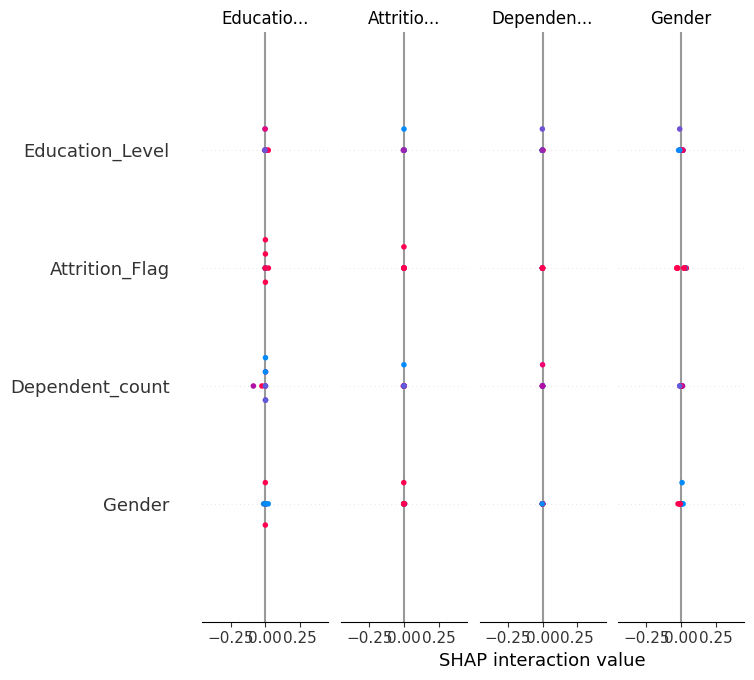

In [20]:
# Perform Model Inversion
shap_values_attack = model_inversion_attack(rf_clf, X_test_scaled_df[:10])

# SHAP Summary Plot to See if Gender is Extractable
shap.summary_plot(shap_values_attack, X_test_scaled_df[:10], feature_names=X.columns)


# -----------------------------
# 🎯 Step 5: Fairness Exploitation (Find Unfair Scenarios)
# -----------------------------

In [21]:
def find_unfair_cases(X_test, y_test, model):
    """
    Identify cases where two similar individuals receive very different credit scores.
    """
    unfair_cases = []
    for i in range(len(X_test) - 1):
        diff = np.abs(X_test.iloc[i] - X_test.iloc[i + 1])
        if diff.sum() < 0.05:  # If two cases are very similar
            pred_1 = model.predict([X_test.iloc[i]])[0]
            pred_2 = model.predict([X_test.iloc[i + 1]])[0]
            if pred_1 != pred_2:
                unfair_cases.append((i, i + 1, pred_1, pred_2))
    
    return unfair_cases

In [22]:
# Find unfair scenarios
unfair_cases = find_unfair_cases(X_test_scaled_df, y_test, rf_clf)

print(f"⚠️ {len(unfair_cases)} Unfair Predictions Found!")


⚠️ 0 Unfair Predictions Found!


# -----------------------------
# ✅ Summary of Attacks
# -----------------------------

In [23]:
print("\n🚀 **Red Teaming Results:**")
print(f"1️⃣ **Evasion Attack**: Fooled the model from '{le_class.inverse_transform([original_prediction])[0]}' → '{le_class.inverse_transform([adversarial_prediction])[0]}'")
print(f"2️⃣ **Data Poisoning**: Accuracy dropped to {accuracy_poisoned:.2f} after injecting bad data.")
print(f"3️⃣ **Model Inversion**: Check SHAP plot to see if sensitive info can be inferred.")
print(f"4️⃣ **Fairness Exploitation**: Found {len(unfair_cases)} cases where similar applicants got different scores.")



🚀 **Red Teaming Results:**
1️⃣ **Evasion Attack**: Fooled the model from 'Poor' → 'Poor'
2️⃣ **Data Poisoning**: Accuracy dropped to 0.59 after injecting bad data.
3️⃣ **Model Inversion**: Check SHAP plot to see if sensitive info can be inferred.
4️⃣ **Fairness Exploitation**: Found 0 cases where similar applicants got different scores.
